In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split



from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding, Dense, Dropout, Conv1D, GlobalMaxPooling1D, BatchNormalization

from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

from gensim.models import Word2Vec
from konlpy.tag import Okt

import pickle
from tensorflow.keras.optimizers import Adam

C:\Anaconda3\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Anaconda3\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
train_data = pd.read_csv("C:/Users/양자/Desktop/Hun_Works/AIFFEL_DLthon/DLThon01/CHYeom/data/syn_sent_augment.csv")

#### 이미 전처리해서 중복 등을 제거한 좋은 데이터로 시작
각 클래스는 정수인코딩 되어있고   
협박 대화 = 0,  
갈취 대화 = 1,  
직장 내 괴롭힘 대화 = 2,  
기타 괴롭힘 대화 = 3,  
일반 = 4   

In [3]:
train_data.head()

,conversation,class
0,너 혼자 . 너와 휘말리게 죽여버릴거야 죽여줄까 네 . . 가족까지 . 도와주세요 ...,0
1,지금 너 스스로를 죽여달라고 애원하는 것인가 거면 ? 아닙니다 . 죄송합니다 . 죽...,0
2,너 스스로를 죽여달라고 애원하는 것인가 아닙니다 . 죄송합니다 . 죽을 거면 혼자 ...,0
3,터지면 . 판단은 . 길동경찰서입니다 진정하세요 ? 말이야 길동경찰서에도 . 한번만...,0
4,길동경찰서입니다 . 시 분 마트에 폭발물을 설치할거다 . 네 ? 폭발물이 똑바로 들...,0


#### 한국어 형태소 분석 후 word2vec

In [4]:
okt=Okt()

tokenized_data = [okt.morphs(sentence) for sentence in train_data['conversation']]

embedding_model = Word2Vec(sentences=tokenized_data,
							sg = 1,
                            vector_size = 128,
                            window = 10,
                            min_count = 1,
                            workers = 4)

In [5]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tokenized_data)
train_X = tokenizer.texts_to_sequences(tokenized_data)

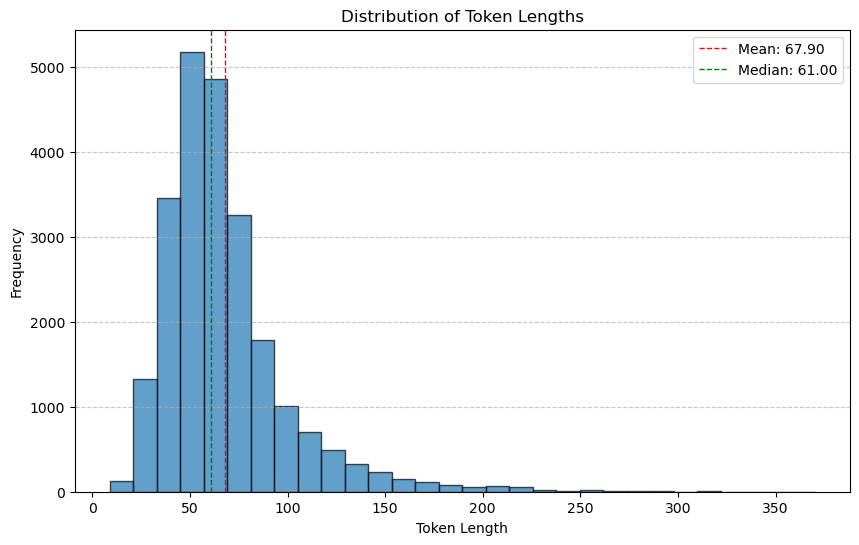

129.0


In [6]:
# Compute token lengths
token_lengths = [len(seq) for seq in train_X]

# Compute statistics
mean_length = np.mean(token_lengths)
std_length = np.std(token_lengths)
min_length = np.min(token_lengths)
max_length = np.max(token_lengths)
median_length = np.median(token_lengths)

# Create a DataFrame for statistics
stats_df = pd.DataFrame({
    "Statistic": ["Mean", "Standard Deviation", "Min", "Max", "Median"],
    "Value": [mean_length, std_length, min_length, max_length, median_length]
})

# Plot histogram of token lengths
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_length:.2f}')
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Distribution of Token Lengths")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(np.percentile(token_lengths, 95))


In [7]:
vocab_size=10000
embedding_dim=256
max_len = 150 # 평균 + 1.5 * 표준편차 한 것 

train_X = tokenizer.texts_to_sequences(tokenized_data)
train_X = pad_sequences(train_X, maxlen=max_len, padding='pre')
train_y = train_data['class'].values

In [8]:
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

In [9]:
print(f"training data size: {len(train_X)}")
print(f"validation data size: {len(val_X)}")

training data size: 18688
validation data size: 4673


### 스태킹 앙상블 기법을 활용하기 위해 kernel_size와 dropout rate이 다른 세 모델 형성

In [10]:
def textcnn_model(kernel_size, dropout):
    model = Sequential()

    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(Conv1D(192, kernel_size=kernel_size, activation='relu', kernel_regularizer=regularizers.l2(0.005)))    
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    model.add(Dense(192, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [11]:
# 모델 3개 생성
TextCNN1 = textcnn_model(kernel_size=3, dropout=0.3)
TextCNN2 = textcnn_model(kernel_size=4, dropout=0.4)
TextCNN3 = textcnn_model(kernel_size=5, dropout=0.5)

# callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# 모델 학습
history1 = TextCNN1.fit(train_X, train_y,
                        batch_size = 32,
                        epochs = 15,
                        validation_data = (val_X, val_y),
                        callbacks=[es, lr]
                       )

history2 = TextCNN2.fit(train_X, train_y,
                        batch_size = 32,
                        epochs = 15,
                        validation_data = (val_X, val_y),
                        callbacks=[es, lr]
                       )

history3 = TextCNN3.fit(train_X, train_y,
                        batch_size = 32,
                        epochs = 15,
                        validation_data = (val_X, val_y),
                        callbacks=[es, lr]
                       )


Epoch 1/15
584/584 [==============================] - 8s 8ms/step - loss: 1.6742 - accuracy: 0.8457 - val_loss: 1.0238 - val_accuracy: 0.9371 - lr: 0.0010
Epoch 2/15
584/584 [==============================] - 4s 8ms/step - loss: 0.5792 - accuracy: 0.9583 - val_loss: 0.4491 - val_accuracy: 0.9655 - lr: 0.0010
Epoch 3/15
584/584 [==============================] - 4s 8ms/step - loss: 0.3498 - accuracy: 0.9710 - val_loss: 0.3368 - val_accuracy: 0.9658 - lr: 0.0010
Epoch 4/15
584/584 [==============================] - 4s 7ms/step - loss: 0.2451 - accuracy: 0.9804 - val_loss: 0.2862 - val_accuracy: 0.9649 - lr: 0.0010
Epoch 5/15
584/584 [==============================] - 4s 7ms/step - loss: 0.2239 - accuracy: 0.9832 - val_loss: 0.2764 - val_accuracy: 0.9626 - lr: 0.0010
Epoch 6/15
584/584 [==============================] - 4s 7ms/step - loss: 0.1943 - accuracy: 0.9838 - val_loss: 0.2468 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 7/15
584/584 [==============================] - 4s 7ms/step - lo

In [12]:
pred_train1 = TextCNN1.predict(train_X)
pred_train2 = TextCNN2.predict(train_X)
pred_train3 = TextCNN3.predict(train_X)
meta_train = np.concatenate([pred_train1, pred_train2, pred_train3], axis=1)

pred_val1 = TextCNN1.predict(val_X)
pred_val2 = TextCNN2.predict(val_X)
pred_val3 = TextCNN3.predict(val_X)
meta_val = np.concatenate([pred_val1, pred_val2, pred_val3], axis=1)

147/147 [==============================] - 0s 2ms/step


In [13]:
print(meta_train[:1])
print(meta_train.shape[1])
print(train_y[:1])

[[1.50052449e-06 2.42137844e-06 6.52112067e-06 9.99989271e-01
  2.40631522e-07 4.09465110e-06 2.51943275e-05 7.82439820e-05
  9.99084234e-01 8.08221637e-04 1.16810725e-05 2.46750260e-05
  7.14911539e-06 9.99933481e-01 2.30572568e-05]]
15
[3]


In [14]:
# 메타 모델
meta_model = Sequential()

meta_model.add(Dense(128, activation='gelu', input_shape=(15,), kernel_regularizer=regularizers.l2(0.01)))
meta_model.add(BatchNormalization())
meta_model.add(Dropout(0.4))
meta_model.add(Dense(64, activation='gelu', kernel_regularizer=regularizers.l2(0.01)))
meta_model.add(BatchNormalization())
meta_model.add(Dropout(0.4))
meta_model.add(Dense(32, activation='gelu', kernel_regularizer=regularizers.l2(0.01)))
meta_model.add(BatchNormalization())
meta_model.add(Dropout(0.4))
meta_model.add(Dense(5, activation='softmax'))

meta_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])

# Stacking 학습
meta_model.fit(meta_train, train_y,
               validation_data=(meta_val, val_y),
               epochs=15,
               batch_size=64,
               callbacks=[es, lr]
              )


Epoch 1/15
292/292 [==============================] - 3s 7ms/step - loss: 0.3699 - accuracy: 0.9902 - val_loss: 0.8157 - val_accuracy: 0.5057 - lr: 0.0050
Epoch 2/15
292/292 [==============================] - 2s 7ms/step - loss: 0.0786 - accuracy: 0.9976 - val_loss: 0.2212 - val_accuracy: 0.9827 - lr: 0.0050
Epoch 3/15
292/292 [==============================] - 2s 7ms/step - loss: 0.1015 - accuracy: 0.9974 - val_loss: 0.1844 - val_accuracy: 0.9910 - lr: 0.0050
Epoch 4/15
292/292 [==============================] - 2s 7ms/step - loss: 0.1147 - accuracy: 0.9982 - val_loss: 0.1939 - val_accuracy: 0.9760 - lr: 0.0050
Epoch 5/15
292/292 [==============================] - 2s 7ms/step - loss: 0.1457 - accuracy: 0.9965 - val_loss: 20.7138 - val_accuracy: 0.3514 - lr: 0.0050


In [15]:
# 검증 데이터 예측
val_preds = meta_model.predict(meta_val)
val_preds_classes = np.argmax(val_preds, axis=1)


147/147 [==============================] - 0s 2ms/step


In [16]:
from sklearn.metrics import f1_score

f1 = f1_score(val_y, val_preds_classes, average="weighted")  # weighted F1-score
print(f"Weighted F1-score: {f1:.4f}")

Weighted F1-score: 0.9910


In [17]:
report = classification_report(val_y, val_preds_classes, target_names=[f"Class {i}" for i in range(5)])
print(report)

              precision    recall  f1-score   support

     Class 0       0.98      0.96      0.97       511
     Class 1       0.99      0.99      0.99       608
     Class 2       1.00      0.99      0.99       577
     Class 3       0.97      0.98      0.98       614
     Class 4       1.00      1.00      1.00      2363

    accuracy                           0.99      4673
   macro avg       0.99      0.99      0.99      4673
weighted avg       0.99      0.99      0.99      4673



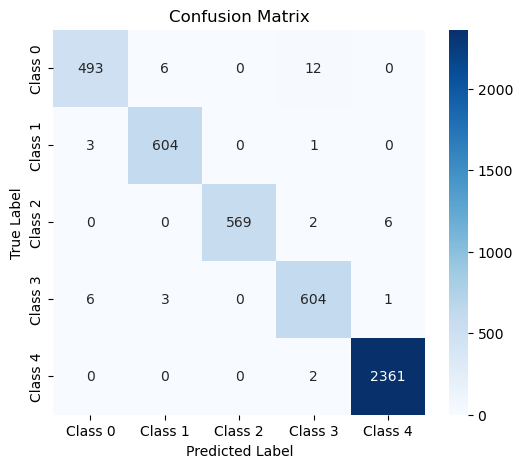

In [18]:
# Confusion Matrix 계산
cm = confusion_matrix(val_y, val_preds_classes)

# Confusion Matrix 시각화
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f"Class {i}" for i in range(5)], yticklabels=[f"Class {i}" for i in range(5)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [19]:
# val_y의 각 클래스 개수 출력
unique_classes, class_counts = np.unique(val_y, return_counts=True)

# 결과 출력
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count}개")


Class 0: 511개
Class 1: 608개
Class 2: 577개
Class 3: 614개
Class 4: 2363개


In [20]:
test_df = pd.read_csv("C:/Users/양자/Desktop/Hun_Works/AIFFEL_DLthon/DLThon01/CHYeom/data/test.csv")

In [21]:
test_texts = test_df['text'].tolist()  # 테스트 데이터의 텍스트 추출
tokenized_test = [okt.morphs(sentence) for sentence in test_texts]  # 형태소 분석 적용
test_X = tokenizer.texts_to_sequences(tokenized_test)  # 기존에 학습된 Tokenizer를 사용해 정수 인덱스로 변환
test_X = pad_sequences(test_X, maxlen=max_len, padding='pre')

print("Test 데이터 Shape:", len(test_X))  # (샘플 수, max_len)

Test 데이터 Shape: 500


In [22]:
pred_test1 = TextCNN1.predict(test_X)
pred_test2 = TextCNN2.predict(test_X)
pred_test3 = TextCNN3.predict(test_X)

meta_test = np.concatenate([pred_test1, pred_test2, pred_test3], axis=1)

16/16 [==============================] - 0s 8ms/step


In [23]:
test_pred = meta_model.predict(meta_test)

16/16 [==============================] - 0s 2ms/step


In [24]:
print(len(test_pred))

500


In [25]:
test_pred[0]

array([1.6898110e-05, 4.5932690e-04, 2.3256540e-05, 9.9948335e-01,
       1.7116403e-05], dtype=float32)

In [26]:
test_pred_labels = np.argmax(test_pred,axis=1)

In [27]:
test_pred_labels[:20]

array([3, 2, 2, 4, 4, 0, 2, 1, 4, 1, 0, 3, 2, 2, 2, 0, 4, 3, 0, 3],
      dtype=int64)

In [28]:
# 인덱스 열 생성 (t_000 ~ t_499)
idx_column = [f"t_{i:03d}" for i in range(len(test_pred_labels))]

# DataFrame 생성
submission_df = pd.DataFrame({
    "idx": idx_column,
    "target": test_pred_labels
})

# 확인
print(submission_df.head(10))  # 상위 10개 출력

# CSV로 저장
submission_df.to_csv("submission_textcnn.csv", index=False)

print("CSV 저장 완료: submission_textcnn.csv")


     idx  target
0  t_000       3
1  t_001       2
2  t_002       2
3  t_003       4
4  t_004       4
5  t_005       0
6  t_006       2
7  t_007       1
8  t_008       4
9  t_009       1
CSV 저장 완료: submission_textcnn.csv


In [29]:
# 클래스 개수 확인
class_distribution = pd.Series(submission_df['target']).value_counts().sort_index()
print(class_distribution)


target
0     87
1    110
2    109
3    138
4     56
Name: count, dtype: int64
